# Wildfire Image Classification Project ML Pipeline 

In [28]:
import gc
import os
import torch
import random
import imagehash
import numpy as np
import pandas as pd
from glob import glob
from math import ceil
import torch.nn as nn
import torch.optim as optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.models import resnet152
from torchvision.models import vit_l_16
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from numpy import ndarray
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from joblib import dump
from functools import partial, reduces
from PIL import Image, ImageFile
from typing import List, Tuple, Set, Any
from collections import Counter
from tqdm.notebook import trange, tqdm

ImageFile.LOAD_TRUNCATED_IMAGES = True
plt.rcParams["figure.facecolor"] = 'w'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device.type

'cuda'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Helper Functions

##### Obtaining (Near) Duplicate Images

Difference hashing (dHash) is used to represent the visual content of images in a compact and consistent manner by converting an image into a hash value that uniquely represents its visual characteristics. The process of dHash is explained [here](https://hackerfactor.com/blog/index.php?/archives/529-Kind-of-Like-That.html).

Following that, KNN is used to find the images with a similar image hashes. The hamming distance measure between the binary of the hashes is used to determine the similarity between images hashes. Similar image will be removed. The underlying data structure used in the KNN is [BallTree](https://en.wikipedia.org/wiki/Ball_tree). 

In [4]:
def getBinaryArrayAsString(arr: ndarray):
  return ''.join('1' if x else '0' for x in arr.hash.flatten())

In [5]:
def removeSimilarImages(image_paths: Set[str], threshold: float) -> Tuple[int, List[Tuple[str, str]], Set[str]]:
  '''
  Removes (Near) duplicate images using Fast-implementation of kNN using BallTree.
  
  Returns:
  - Number of images with exact hash
  - A list pairs of near duplicate images where the second path is the removed path
  - A list of image paths that is free from any near duplicate images to the specified threshold
  '''
  
  def process_similar_items(removed_path: Set[str], distances: ndarray, indices: ndarray, curr_path: str) -> bool:
    for i in range(0, len(distances)):
      similarHashKey = ''.join(data[indices[i]].flatten())
      similarity = 1 - distances[i]
      
      if similarity >= threshold:
        similarPath = hash_image_dict[similarHashKey]
        near_duplicates.append((curr_path, similarPath))
        removed_path.add(similarPath)
      else:
        return False
    return True

  hash_image_dict = {getBinaryArrayAsString(imagehash.dhash(Image.open(path))): path for path in image_paths}
  num_exact_images = len(image_paths) - len(hash_image_dict)
  near_duplicates = [] 
  removed_path = set()
  
  data = np.array([list(value) for value in list(hash_image_dict.keys())])
  ballt = BallTree(data, metric='hamming')

  for hash, path in tqdm(hash_image_dict.items(), desc="Processing Images", leave=False):
    if (path in removed_path):
      continue
    
    k = 1   
    need_to_increase_k = True
    while need_to_increase_k:
      distances, indices = ballt.query([list(hash)], k=(k + 5), return_distance=True, sort_results=True)
      distances = distances.flatten()[k:]
      indices = indices.flatten()[k:]
      need_to_increase_k = process_similar_items(removed_path, distances, indices, path)
      k += 5

  remaining_paths = set(image_paths) - removed_path
  return (num_exact_images, near_duplicates, remaining_paths)  

##### Plotting Helper Functions

This section includes different method used to abstract the plot logic

In [6]:
def plotImagePairs(image_paths: List[Tuple[str, str]], title: str) -> None:
  assert len(image_paths) > 0, 'image_paths must contain at least one pair'
  
  fig, axs = plt.subplots(nrows=len(image_paths), ncols=2, figsize=(6, 3 * len(image_paths)))
  suptitle = fig.suptitle(title, fontsize=16)

  if (len(image_paths) == 1):
    axs[0].set_title(f'First Image')
    axs[1].set_title(f'Second Image')
    first_image = Image.open(image_paths[0][0]).resize([24, 24])
    second_image = Image.open(image_paths[0][1]).resize([24, 24])

    axs[0].imshow(first_image)
    axs[1].imshow(second_image)
    suptitle.set_y(1.02)
    plt.show()
    return
  
  axs[0,0].set_title(f'First Image')
  axs[0,1].set_title(f'Second Image')
  for i in range(len(image_paths)):
    first_image = Image.open(image_paths[i][0]).resize([24, 24])
    second_image = Image.open(image_paths[i][1]).resize([24, 24])

    axs[i,0].imshow(first_image)
    axs[i,1].imshow(second_image)

  first_subplot_position = axs[0, 0].get_position()
  first_subplot_y = first_subplot_position.y1
  suptitle.set_y(first_subplot_y + 0.2 / len(image_paths))
  plt.show()

In [7]:
def plotBarGraph(groups: List[str], values: List[int], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(values), 'Groups and values must have the same length'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, values, color='#003f5c')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.set_ylim(bottom=0)
  plt.show()

In [8]:
def plot2StackedBarGraph(groups: List[str], first_values: List[int], second_values: List[int], legend: List[str], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(first_values) == len(second_values), 'Groups and values must have the same length'
  assert len(legend) == 2, 'Legend should have a length of 2'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, first_values, label=legend[0], color='#003f5c')
  axs.bar(groups, second_values, bottom = first_values, label=legend[1], color='#bc5090')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.legend()
  axs.set_ylim(bottom=0)
  plt.show()

In [9]:
def plot3StackedBarGraph(groups: List[str], first_values: List[int], second_values: List[int], third_values: List[int], legend: List[str], title: str) -> None:
  assert len(groups) > 0, 'Groups must be at least 1'
  assert len(groups) == len(first_values) == len(second_values) == len(third_values), 'Groups and values must have the same length'
  assert len(legend) == 3, 'Legend should have a length of 3'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.bar(groups, first_values, label=legend[0], color='#003f5c')
  axs.bar(groups, second_values, bottom = first_values, label=legend[1], color='#bc5090')
  axs.bar(groups, third_values, bottom = np.add(first_values, second_values), label=legend[2], color='#ffa600')
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.legend()
  axs.set_ylim(bottom=0)
  plt.show()

In [27]:
def plotPieChartGraph(title: str, sizes: List[int], labels: List[str], explode: List[int]) -> None:
  assert len(labels) > 0, 'Labels must be at least 1'
  assert len(labels) == len(sizes) == len(explode), 'Labels, sizes, and explode must have the same length'
  
  plt.pie(sizes, labels=labels, autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.3, explode=explode, shadow=True, startangle=90)
  plt.suptitle(title, fontsize=16, y=0.95)
  plt.figure(facecolor='white')
  plt.show()

In [6]:
def plotLineChartGraph(title: str, data: List[float], axs_labels: List[str]) -> None:
  assert len(data) > 0, 'Data must be contain at least 1 point'
  assert len(axs_labels) == 2, 'axs_labels must contain 2 elements'
  
  fig, axs = plt.subplots()
  fig.suptitle(title, fontsize=16, y=0.97)
  axs.plot(data)
  axs.yaxis.set_major_locator(MaxNLocator(integer=True))
  axs.set_xlabel(axs_labels[0])
  axs.set_ylabel(axs_labels[1])
  plt.show()

##### Image Helper Methods

This function aims to indicate if an image is corrupted or not 

In [7]:
def isImageValid(image_path: str) -> bool:
  try:
    img = Image.open(image_path)
    _ = img.convert('RGB')
    return True
  except:
    return False

##### Model Training and Evaluation

These functions aim to abstract the model training and testing logic.

In [22]:
def trainModel(train_loader: DataLoader, criterion: nn.CrossEntropyLoss, optimizer: Any, model: Any, max_epoch: int, stopping_threshold: float) -> List[float]:
  '''
  This function includes the main training loop for the passed model.
  
  Returns:
  - List of losses per epoch
  '''
  
  loss_values = []
  for epoch in trange(max_epoch, desc="Main Training Loop", leave=False):
    running_loss = 0.0
    for _, data in tqdm(enumerate(train_loader, 0), desc="Batch Loop", leave=False, total=len(train_loader)):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      current_loss = loss.item()
      running_loss += current_loss
    
    loss_values.append(running_loss / len(train_loader.dataset))
    if (epoch >= 1 and abs(loss_values[-1] - loss_values[-2]) <= stopping_threshold):
      print('Stop threshold reached')
      print(f'[{epoch+1}] loss: {running_loss / len(train_loader.dataset):.3f}')
      break
              
  return loss_values

In [9]:
def testModel(test_loader: DataLoader, model: Any, classes: List[str]) -> None:
  '''
  This function includes the main training loop for the passed model.
  
  Returns:
  - Dictionary of the number of total predicted for each class
  - Dictionary of the number of correctly labels for each class
  - Number of false positives with respect to class_0
  - Number of false negatives with respect to class_0
  '''
  correct_pred = {classname: 0 for classname in classes}
  false_positive = 0
  false_negative = 0
  total_pred = {classname: 0 for classname in classes}

  with torch.no_grad():
    for data in tqdm(test_loader, desc="Main Testing Loop", leave=False):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)

      for label, prediction in zip(labels, predictions):
        total_pred[classes[label]] += 1
        if label == prediction:
          correct_pred[classes[label]] += 1
        else:
          if label.item() == 0:
            false_negative += 1
          else:
            false_positive += 1
  
  return (total_pred, correct_pred, false_positive, false_negative)

### Hyper-Parameters

In [19]:
SIMILARITY_THRESHOLD = 0.80
IMAGE_SIZE = 224
BATCH_SIZE = 32
TRAIN_PERC = 0.8
MAX_EPOCH  = 2

CUSTOMNET_LEARNING_RATE = 0.001
CUSTOMNET_MOMENTUM = 0.9
CUSTOMNET_LOSS_THRESHOLD = 1e-6
CUSTOMNET_KERNEL_SIZE = 3
CUSTOMNET_OUTPUT_CHANNELS = [12, 20, 32]
CUSTOMNET_STRIDE = 1

RESNET_LEARNING_RATE = 0.001
RESNET_MOMENTUM = 0.9
RESNET_LOSS_THRESHOLD = 1e-6

ViT_LEARNING_RATE = 0.001
ViT_MOMENTUM = 0.9
ViT_LOSS_THRESHOLD = 1e-6

NUMBER_OF_CLUSTERS = 2

### Image Preprocessing

##### Image Augmentation

The transformation will include the following:
- Resize: To make sure all the images will have the same size
- RandomHorizontalFlip: Data augmentation
- ToTensor: Since we are using pytorch it expects a tensor not a numpy; it will convert the values from 0-255 to 0-1
- Normalize: Normalises the mean and standard deviation of the rgb values to 0.5 for each of the 3 channels

In [11]:
transformer=transforms.Compose([
  transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
  transforms.RandomHorizontalFlip(),
  transforms.ToTensor(), 
  transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
])

##### Data Loader

This section will perfrom the following:
- Load the dataset
- Remove corrupt images
- Remove duplicate images
- Split the dataset

In [12]:
data_path = os.path.join('data')

wildfire_paths = os.path.join('data', 'wildfire')
nowildfire_paths = os.path.join('data', 'nowildfire')

In [13]:
wildfire_image_paths = glob(wildfire_paths + '/*.jpg')
valid_wildfire_image_paths = [path for path in wildfire_image_paths if isImageValid(path)]
nowildfire_image_paths = glob(nowildfire_paths + '/*.jpg')
valid_nowildfire_image_paths = [path for path in nowildfire_image_paths if isImageValid(path)]

In [ ]:
(num_exact_images_wildfire, near_duplicates_wildfire, remaining_paths_wildfire) = removeSimilarImages(valid_wildfire_image_paths, SIMILARITY_THRESHOLD)

In [ ]:
(num_exact_images_nowildfire, near_duplicates_nowildfire, remaining_paths_nowildfire) = removeSimilarImages(valid_nowildfire_image_paths, SIMILARITY_THRESHOLD)

In [16]:
def isValidFile(image_path: str, valid_paths: List[str]) -> bool:
  return image_path in valid_paths

valid_data_paths = remaining_paths_wildfire.union(remaining_paths_nowildfire)
isValidDataFile = partial(isValidFile, valid_paths=valid_data_paths)

In [17]:
dataset = ImageFolder(data_path, transform=transformer, is_valid_file=isValidDataFile)
train_size = int(TRAIN_PERC * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

##### Data Analysis

This section aims to visualise the distribution and characteristics of the loaded data, including data distribution, number of corrupted image files, comparison between unique and duplicate images, and identification of exact and near-duplicate images.

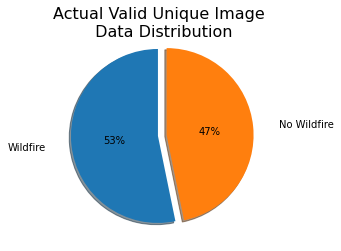

<Figure size 432x288 with 0 Axes>

In [29]:
classes = ['Wildfire', 'No Wildfire']
class_idx = dataset.class_to_idx
class_instance = dict(Counter(dataset.targets))

obtained_wildfire_count = class_instance[class_idx['wildfire']]
obtained_nowildfire_count = class_instance[class_idx['nowildfire']]

plotPieChartGraph(title='Actual Valid Unique Image \n Data Distribution', sizes=[obtained_wildfire_count, obtained_nowildfire_count], labels=classes, explode=[0.1, 0])

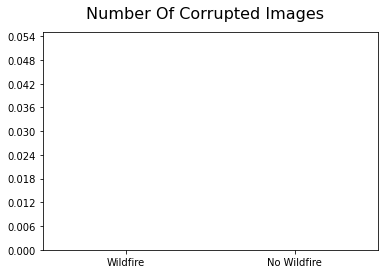

In [29]:
original_wildfire_count = len(wildfire_image_paths)
original_nowildfire_count = len(nowildfire_image_paths)

valid_wildfire_count = len(valid_wildfire_image_paths)
valid_nowildfire_count = len(valid_nowildfire_image_paths)

corrupted_wildfire_count = original_wildfire_count - valid_wildfire_count
corrupted_nowildfire_count = original_nowildfire_count - valid_nowildfire_count

plotBarGraph(groups=classes, values=[corrupted_wildfire_count, corrupted_nowildfire_count], title='Number Of Corrupted Images')

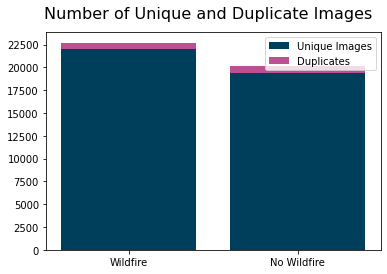

In [30]:
near_duplicates_wildfire_as_set = set([path[1] for path in near_duplicates_wildfire])
near_duplicates_nowildfire_as_set = set([path[1] for path in near_duplicates_nowildfire])

near_duplicates_wildfire_count = len(near_duplicates_wildfire_as_set)
near_duplicates_nowildfire_count = len(near_duplicates_nowildfire_as_set)

first_values = [obtained_wildfire_count, obtained_nowildfire_count]
second_values = [near_duplicates_wildfire_count + num_exact_images_wildfire, near_duplicates_nowildfire_count + num_exact_images_nowildfire]
legend = ['Unique Images', 'Duplicates']
plot2StackedBarGraph(classes, first_values, second_values, legend, 'Number of Unique and Duplicate Images')

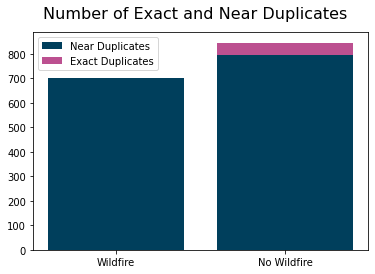

In [31]:
first_values = [near_duplicates_wildfire_count, near_duplicates_nowildfire_count]
second_values = [num_exact_images_wildfire, num_exact_images_nowildfire]
legend = ['Near Duplicates', 'Exact Duplicates']
plot2StackedBarGraph(classes, first_values, second_values, legend, 'Number of Exact and Near Duplicates')

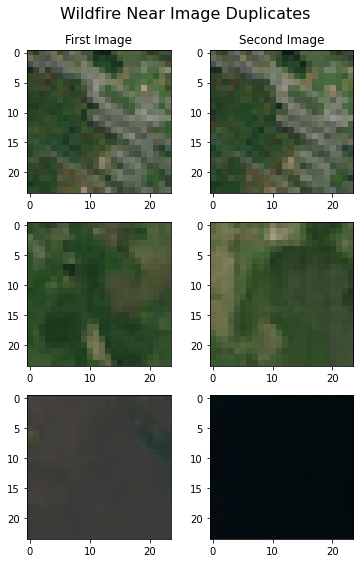

In [35]:
subsample_wildfire_near_duplicates = random.sample(near_duplicates_wildfire, 3)
plotImagePairs(subsample_wildfire_near_duplicates, title='Wildfire Near Image Duplicates')

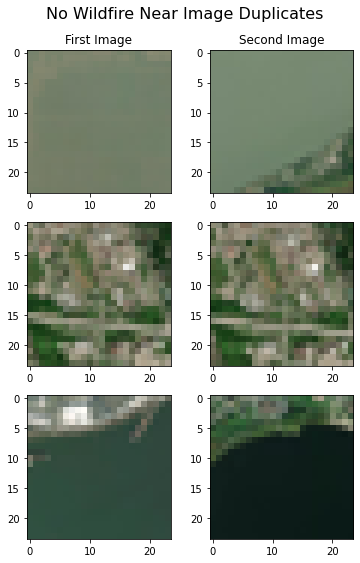

In [72]:
subsample_nowildfire_near_duplicates = random.sample(near_duplicates_nowildfire, 3)
plotImagePairs(subsample_nowildfire_near_duplicates, title='No Wildfire Near Image Duplicates')

### Custom CNN

CNNs process data in a hierarchical manner through layers of filters, capturing features like edges and textures. These filters slide over the input, extracting information and passing it to subsequent layers. Pooling layers downsample the data, while fully connected layers perform classification or regression tasks based on learned features. More information regarding CNN can be obtained [here](https://en.wikipedia.org/wiki/Convolutional_neural_network). The following shows a single layer of the custom made ShallowNet model. Please note that the ShallowNet model consists of 3 layers and a final linear layer.

![ShallowNetArch](notebook_image_src/shallowNet_arch.jpg)

An instance of the trained model weights can be obtained from [here](https://drive.google.com/file/d/1wQE563yeNghkSunqZ7rJfF7N1cH6SLGk/view?usp=sharing)

##### Create Model

In [18]:
class ShallowNet(nn.Module):
  def __init__(self, image_size: int, out_channels: List[int], kernel_size: int, stride_size: int, classes_num: int) -> None:
    super(ShallowNet, self).__init__()
    assert len(out_channels) == 3, 'There must be 3 output channel values since there are 3 conv layers'

    padding_size = ceil(((stride_size - 1) * image_size - stride_size + kernel_size) / 2)
    poolling_size = 2

    new_image_size_after_one_round = ShallowNet.calculate_image_size_after_conv_layer(image_size, padding_size, kernel_size, stride_size)
    new_image_size_after_two_round = ShallowNet.calculate_image_size_after_conv_layer(new_image_size_after_one_round // poolling_size, padding_size, kernel_size, stride_size)
    new_image_size_after_third_round = ShallowNet.calculate_image_size_after_conv_layer(new_image_size_after_two_round // poolling_size, padding_size, kernel_size, stride_size)
    new_image_size_after_third_round = new_image_size_after_third_round // poolling_size

    assert new_image_size_after_third_round % 2 == 0, 'There will be loss of data due to the image size'

    final_flatten_size =  new_image_size_after_third_round * new_image_size_after_third_round * out_channels[-1]

    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=out_channels[0], kernel_size=kernel_size, stride=stride_size, padding=padding_size),
      nn.BatchNorm2d(out_channels[0]), 
      nn.MaxPool2d(poolling_size), 
      nn.ReLU(),

      nn.Conv2d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=kernel_size, stride=stride_size, padding=padding_size), 
      nn.BatchNorm2d(out_channels[1]),
      nn.MaxPool2d(poolling_size), 
      nn.ReLU(), 

      nn.Conv2d(in_channels=out_channels[1], out_channels=out_channels[2], kernel_size=kernel_size, stride=stride_size, padding=padding_size), 
      nn.BatchNorm2d(out_channels[2]), 
      nn.MaxPool2d(poolling_size), 
      nn.ReLU(), 
    )

    self.linear_layers = nn.Sequential(nn.Linear(in_features=final_flatten_size, out_features=classes_num))
  
  def forward(self, input: torch.Tensor):
    self._validate_input_size(input)

    output = self.conv_layers(input)
    flatten_batch_size = reduce(lambda x, y: x * y, output.shape[1:])
    output = output.view(-1, flatten_batch_size)
    output = self.linear_layers(output)

    return output

  def _validate_input_size(self, input: torch.Tensor):
    shape = input.shape
    assert len(shape) == 4, 'Input shape must look like: (_, _, _, _)'
    assert shape[1] == 3, 'Input must have 3 channels'
    assert shape[2] == shape[3], 'Input must be a square image'
  
  @staticmethod
  def calculate_image_size_after_conv_layer(image_size: int, padding_size: int, kernel_size: int, stride_size: int) -> int:
    new_image_size = ((image_size + 2 * padding_size - kernel_size) / stride_size) + 1
    assert int(new_image_size) == new_image_size, 'The output size after one conv layer is not an integer'
    return int(new_image_size)

##### Fit Model

In [20]:
shallownet_model = ShallowNet(IMAGE_SIZE, CUSTOMNET_OUTPUT_CHANNELS, CUSTOMNET_KERNEL_SIZE, CUSTOMNET_STRIDE, classes_num=2)
shallownet_model = shallownet_model.to(device)

shallownet_criterion = nn.CrossEntropyLoss()
shallownet_optimizer = optim.SGD(shallownet_model.parameters(), lr=RESNET_LEARNING_RATE, momentum=RESNET_MOMENTUM)

In [ ]:
loss_values = trainModel(train_loader, shallownet_criterion, shallownet_optimizer, shallownet_model, MAX_EPOCH, RESNET_LOSS_THRESHOLD)
torch.save(shallownet_model.state_dict(), './shallownet_model.pth')

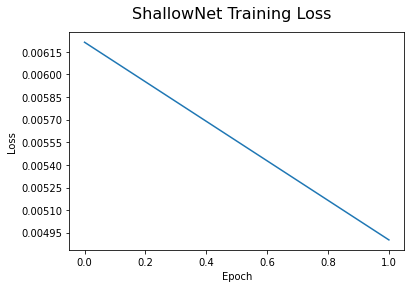

In [24]:
plotLineChartGraph('ShallowNet Training Loss', loss_values, ['Epoch', 'Loss'])

##### Test Model

In [ ]:
total_pred, correct_pred, false_positive, false_negative = testModel(test_loader, shallownet_model, classes)

In [31]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
precision = correct_pred['Wildfire'] / (correct_pred['Wildfire'] + false_positive)
recall = correct_pred['Wildfire'] / (correct_pred['Wildfire'] + false_negative)
f1_score = 2*precision*recall / (precision+recall)

print(f'Precision for class: Wildfire is {precision:.1f}')
print(f'Recall for class: Wildfire is {recall:.1f}')
print(f'F1 Score for class: Wildfire is {f1_score:.1f}')

Accuracy for class: Wildfire is 95.1 %
Accuracy for class: No Wildfire is 93.9 %
Precision for class: Wildfire is 0.9
Recall for class: Wildfire is 1.0
F1 Score for class: Wildfire is 0.9


### ResNet152

ResNet is a type of CNN that utilizes skip connections to tackle the challenge of training very deep networks effectively such as vanishing gradient. This innovation enables training of deeper models with hundreds of layers, leading to state-of-the-art performance in various tasks including image classification. The following image shows the difference from architectural point of view between ResNet, VGG (another type of CNN), and plain CNN (image was obtained from [Deep Residual Learning for Image Recognition Paper](https://arxiv.org/pdf/1512.03385.pdf)). Please note that the ResNet model being used is 152 layers.

![ResnetArch](notebook_image_src/resnet_arch.png)

An instance of the trained model weights can be obtained from [here](https://drive.google.com/file/d/1_82K3Xp0aaJg6-q69aftSQhZdUn6DzDh/view?usp=sharing)

##### Fit Model

In [24]:
resnet152_model = resnet152(weights=None)
resnet152_model = resnet152_model.to(device)

resnet152_criterion = nn.CrossEntropyLoss()
resnet152_optimizer = optim.SGD(resnet152_model.parameters(), lr=RESNET_LEARNING_RATE, momentum=RESNET_MOMENTUM)

In [ ]:
loss_values = trainModel(train_loader, resnet152_criterion, resnet152_optimizer, resnet152_model, MAX_EPOCH, RESNET_LOSS_THRESHOLD)
torch.save(resnet152_model.state_dict(), './resnet_model.pth')

In [ ]:
plotLineChartGraph('ResNet Training Loss', loss_values, ['Epoch', 'Loss'])

##### Test Model

In [ ]:
total_pred, correct_pred, false_positive, false_negative = testModel(test_loader, resnet152_model, classes)

In [83]:
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
    
precision = correct_pred['Wildfire'] / (correct_pred['Wildfire'] + false_positive)
recall = correct_pred['Wildfire'] / (correct_pred['Wildfire'] + false_negative)
f1_score = 2*precision*recall / (precision+recall)

print(f'Precision for class: Wildfire is {precision:.1f}')
print(f'Recall for class: Wildfire is {recall:.1f}')
print(f'F1 Score for class: Wildfire is {f1_score:.1f}')

Accuracy for class: Wildfire is 81.4 %
Accuracy for class: No Wildfire is 93.4 %
Precision for class: Wildfire is 0.9
Recall for class: Wildfire is 0.8
F1 Score for class: Wildfire is 0.9


In [ ]:
del resnet152_model
del resnet152_criterion
del resnet152_optimizer
gc.collect()
torch.cuda.empty_cache()

### ViT

ViT, or Vision Transformer, is a novel architecture for image processing that diverges from traditional Convolutional Neural Networks (CNNs). Unlike traditional CNNs that rely solely on convolutional layers for feature extraction, ViT adopts a [transformer](https://arxiv.org/abs/1706.03762) architecture originally designed for sequence processing tasks. This allows ViT to process images by dividing them into fixed-size patches, treating them as sequences of tokens, and applying self-attention mechanisms to capture long-range dependencies. Thus, ViT represents a novel approach to image processing within the CNN framework. The following image shows the architecture of the model (image was obtained from [An image is worth 16x16 words: Transformers for image recognition at scale paper](https://arxiv.org/abs/2010.11929))

![ResnetArch](notebook_image_src/vit_arch.png)

An instance of the trained model weights can be obtained from [here](https://drive.google.com/file/d/1x2pPJr5upD8juCKqGL_qa9OTeg7wPHfT/view?usp=sharing)

##### Fit Model

In [ ]:
vit_model = vit_l_16(weights=None)
vit_model = vit_model.to(device)

vit_criterion = nn.CrossEntropyLoss()
vit_optimizer = optim.SGD(vit_model.parameters(), lr=ViT_LEARNING_RATE, momentum=ViT_MOMENTUM)

In [ ]:
loss_values = trainModel(train_loader, vit_criterion, vit_optimizer, vit_model, MAX_EPOCH, ViT_LOSS_THRESHOLD)
torch.save(vit_model.state_dict(), './vit_model.pth')

In [ ]:
plotLineChartGraph('ViT Training Loss', loss_values, ['Epoch', 'Loss'])

##### Test Model

In [ ]:
total_pred_ViT, correct_pred_ViT, false_positive_ViT, false_negative_ViT = testModel(test_loader, resnet152_model, classes)

In [62]:
print("Accuracy")
for classname, correct_count in correct_pred_ViT.items():
    accuracy = 100 * float(correct_count) / total_pred_ViT[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

precision = correct_pred_ViT['Wildfire'] / (correct_pred_ViT['Wildfire'] + false_positive_ViT)
recall = correct_pred_ViT['Wildfire'] / (correct_pred_ViT['Wildfire'] + false_negative_ViT)
f1_score = 2*precision*recall / (precision+recall)

print(f'Precision for class: Wildfire is {precision:.1f}')
print(f'Recall for class: Wildfire is {recall:.1f}')
print(f'F1 Score for class: Wildfire is {f1_score:.1f}')

Accuracy
Accuracy for class: Wildfire is 40.9 %
Accuracy for class: No Wildfire is 99.3 %
Precision for class: Wildfire is 1.0
Recall for class: Wildfire is 0.4
F1 Score for class: Wildfire is 0.6


In [ ]:
del vit_model
del vit_criterion
del vit_optimizer
gc.collect()
torch.cuda.empty_cache()

### K-Means

K-means is an unsupervised machine learning algorithm that groups data into clusters based on similarities. It iteratively assigns data points to clusters with the nearest centroid and updates centroids until convergence. The image data is flatten and then inputted to the K-means model. Initialization method is K-means++.

##### Fit Model

In [ ]:
# Training Step
def convertTensorObjectToNPArray(dataset):
  features = []
  for data, _ in dataset:
    features.append(data.numpy().flatten())

  features = np.array(features)
  return features

train_dataset_array = convertTensorObjectToNPArray(train_dataset)

kmeans = KMeans(n_clusters=NUMBER_OF_CLUSTERS,  random_state=0, n_init="auto")
cluster_labels = kmeans.fit_predict(train_dataset_array)

dump(kmeans, 'kmeans_model.joblib')

##### Anaylse Clusters

In [103]:
# Count number of instances for each cluster
unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts = counts.reshape(1, 2)

countscldf = pd.DataFrame(counts, columns = ["Cluster 1", "Cluster 2"])
countscldf

,Cluster 1,Cluster 2
0,536,548


For n_clusters = 2 The average silhouette_score is : 0.18594486


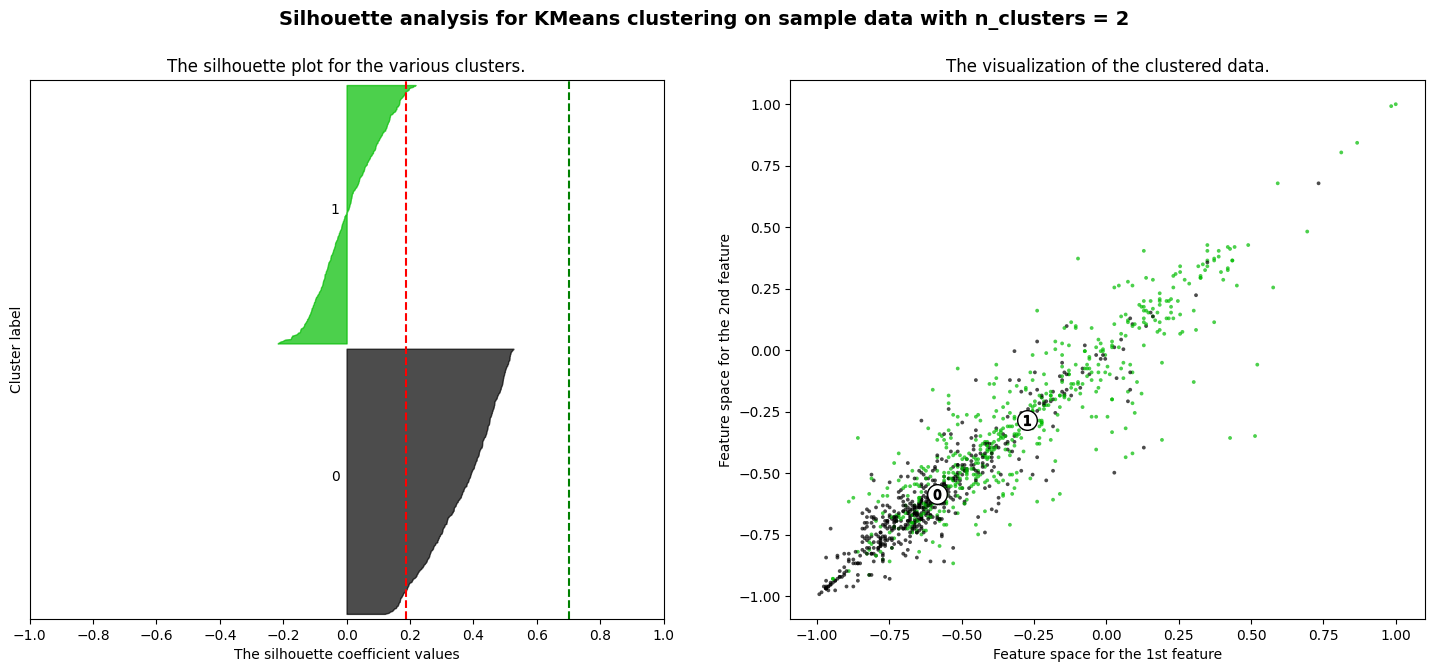

In [107]:
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2) # ax1 is the silhouette plot and ax2 is the clustered visualization
fig.set_size_inches(18, 7)

ax1.set_xlim([-1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(train_dataset_array) + (NUMBER_OF_CLUSTERS + 1) * 10])


# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(train_dataset_array, cluster_labels)
print(
    "For n_clusters =",
    NUMBER_OF_CLUSTERS,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(train_dataset_array, cluster_labels)

y_lower = 10
for i in range(NUMBER_OF_CLUSTERS):
    # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / NUMBER_OF_CLUSTERS)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.axvline(x=0.7, color="green", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(cluster_labels.astype(float) / NUMBER_OF_CLUSTERS)
ax2.scatter(
    train_dataset_array[:, 0], train_dataset_array[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
)

# Labeling the clusters
centers = kmeans.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(
    centers[:, 0],
    centers[:, 1],
    marker="o",
    c="white",
    alpha=1,
    s=200,
    edgecolor="k",
)

for i, c in enumerate(centers):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % NUMBER_OF_CLUSTERS,
    fontsize=14,
    fontweight="bold",
)

plt.show()

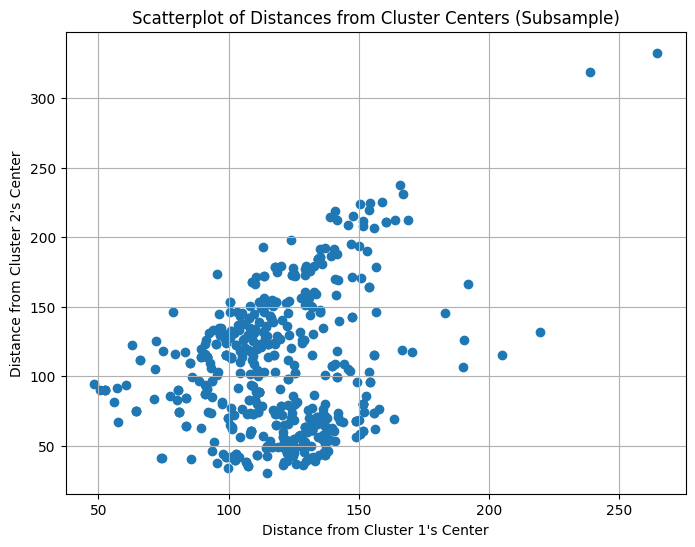

In [105]:
# Plot a Scatterplot of the distance from cluster 1's center against the distance from cluster's center 2
cluster_centers = kmeans.cluster_centers_

# Calculate distances for a subsample of points
subsample_size = 500  # Adjust this as needed
subsample_indices = np.random.choice(len(train_dataset_array), size=subsample_size)
subsample_points = train_dataset_array[subsample_indices]

distances_from_center1 = np.linalg.norm(subsample_points - cluster_centers[0], axis=1)
distances_from_center2 = np.linalg.norm(subsample_points - cluster_centers[1], axis=1)

plt.figure(figsize=(8, 6))
plt.scatter(distances_from_center1, distances_from_center2)

plt.xlabel("Distance from Cluster 1's Center")
plt.ylabel("Distance from Cluster 2's Center")
plt.title("Scatterplot of Distances from Cluster Centers (Subsample)")
plt.grid(True)
